In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "./PreprocessedAll5/"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})
print(df_train_kaggle.shape)

(9786, 2)


Text(0, 0.5, 'count')

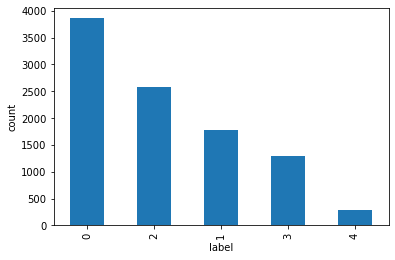

In [3]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [4]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9786 validated image filenames.


In [6]:
compi_root_path= "./PreprocessedValidation/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,./PreprocessedValidation/train/Image_1.jpg,0
1,./PreprocessedValidation/train/Image_2.jpg,1
2,./PreprocessedValidation/train/Image_3.jpg,0
3,./PreprocessedValidation/train/Image_4.jpg,1
4,./PreprocessedValidation/train/Image_5.jpg,2


Text(0, 0.5, 'count')

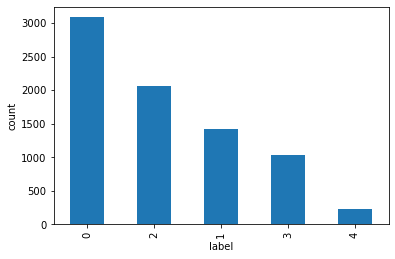

In [7]:
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [8]:


# Step 1: Split validation data into x_val and x_test
x_val, x_test = train_test_split(df_val_compi, test_size=0.35, random_state=42)

# Create separate generators for x_val and x_test
val_generator = valid_aug.flow_from_dataframe(
    dataframe=x_val,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)

test_generator = valid_aug.flow_from_dataframe(
    dataframe=x_test,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)


Found 5088 validated image filenames.
Found 2740 validated image filenames.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained VGG19 model with ImageNet weights
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Combine the base model with custom classification head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
306/306 [==============================] - 81s 230ms/step - loss: 1.4020 - accuracy: 0.3945 - val_loss: 1.3696 - val_accuracy: 0.4283
Epoch 2/10
306/306 [==============================] - 67s 220ms/step - loss: 1.3441 - accuracy: 0.4269 - val_loss: 1.3267 - val_accuracy: 0.4169
Epoch 3/10
306/306 [==============================] - 70s 227ms/step - loss: 1.3022 - accuracy: 0.4474 - val_loss: 1.2673 - val_accuracy: 0.4491
Epoch 4/10
306/306 [==============================] - 71s 234ms/step - loss: 1.2594 - accuracy: 0.4640 - val_loss: 1.2483 - val_accuracy: 0.4703
Epoch 5/10
306/306 [==============================] - 70s 228ms/step - loss: 1.2363 - accuracy: 0.4753 - val_loss: 1.2169 - val_accuracy: 0.4784
Epoch 6/10
306/306 [==============================] - 67s 220ms/step - loss: 1.2251 - accuracy: 0.4757 - val_loss: 1.2016 - val_accuracy: 0.4898
Epoch 7/10
306/306 [==============================] - 67s 220ms/step - loss: 1.2124 - accuracy: 0.4821 - val_loss: 1.1823 - val_ac

In [11]:
checkpoint_path = "vgg19_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained VGG19 model with ImageNet weights
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(base_model.output)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

# Global pooling layer
GAP = GlobalAveragePooling2D()(x)

# Output layer
n_classes = 5  # Number of classes in your output
pred = Dense(n_classes, activation='softmax')(GAP)

# Define the model
vgg19_model = Model(inputs=base_model.input, outputs=pred)

# Compile the model
vgg19_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

vgg19_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [13]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

In [14]:
vgg19_model.fit(
    train_generator,
    epochs=22,
    validation_data=val_generator,
    callbacks=[my_callbacks],
    class_weight=class_weights
)

Epoch 1/22
306/306 [==============================] - ETA: 0s - loss: 1.3547 - acc: 0.3363
Epoch 1: val_acc improved from -inf to 0.48153, saving model to vgg19_best.ckpt
306/306 [==============================] - 73s 233ms/step - loss: 1.3547 - acc: 0.3363 - val_loss: 1.3602 - val_acc: 0.4815 - lr: 1.0000e-05
Epoch 2/22
306/306 [==============================] - ETA: 0s - loss: 1.1652 - acc: 0.4519
Epoch 2: val_acc improved from 0.48153 to 0.53341, saving model to vgg19_best.ckpt
306/306 [==============================] - 68s 222ms/step - loss: 1.1652 - acc: 0.4519 - val_loss: 1.1536 - val_acc: 0.5334 - lr: 1.0000e-05
Epoch 3/22
306/306 [==============================] - ETA: 0s - loss: 1.0745 - acc: 0.5113
Epoch 3: val_acc improved from 0.53341 to 0.55818, saving model to vgg19_best.ckpt
306/306 [==============================] - 73s 239ms/step - loss: 1.0745 - acc: 0.5113 - val_loss: 1.1582 - val_acc: 0.5582 - lr: 1.0000e-05
Epoch 4/22
306/306 [==============================] - ETA:

In [15]:
vgg19_model.load_weights(checkpoint_path)


In [16]:
# Step 2: Use your model to predict labels for x_test
predictions = vgg19_model.predict(test_generator)

# Step 3: Evaluate the predictions using a confusion matrix
true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

86/86 [==============================] - 17s 191ms/step
Confusion Matrix:
[[953 104  39   0   1]
 [ 27 461   4   0   0]
 [ 46  38 646   1   2]
 [  1   3   6 322   4]
 [  0   0   0   0  82]]


In [17]:

report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1097
           1       0.76      0.94      0.84       492
           2       0.93      0.88      0.90       733
           3       1.00      0.96      0.98       336
           4       0.92      1.00      0.96        82

    accuracy                           0.90      2740
   macro avg       0.91      0.93      0.92      2740
weighted avg       0.91      0.90      0.90      2740



In [18]:
vgg19_model.save('vgg19_model.h5')

In [19]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(base_model.output)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

n_classes = 5  # Number of classes in your output
x = Conv2D(filters=n_classes, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

# Global pooling layer
GAP = GlobalAveragePooling2D()(x)

# Output layer
pred = Dense(n_classes, activation='softmax')(GAP)

# Define the model
xception_model = Model(inputs=base_model.input, outputs=pred)

# Compile the model
xception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

xception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [20]:
# compile
xception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

In [21]:
# train the model
xception_model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)


Epoch 1/20
306/306 [==============================] - ETA: 0s - loss: 1.3725 - acc: 0.3942
Epoch 1: val_acc improved from -inf to 0.47740, saving model to xception_best.ckpt
306/306 [==============================] - 88s 271ms/step - loss: 1.3725 - acc: 0.3942 - val_loss: 1.3727 - val_acc: 0.4774 - lr: 1.0000e-05
Epoch 2/20
306/306 [==============================] - ETA: 0s - loss: 1.1973 - acc: 0.4871
Epoch 2: val_acc improved from 0.47740 to 0.54363, saving model to xception_best.ckpt
306/306 [==============================] - 78s 253ms/step - loss: 1.1973 - acc: 0.4871 - val_loss: 1.2495 - val_acc: 0.5436 - lr: 1.0000e-05
Epoch 3/20
306/306 [==============================] - ETA: 0s - loss: 1.0956 - acc: 0.5483
Epoch 3: val_acc improved from 0.54363 to 0.55464, saving model to xception_best.ckpt
306/306 [==============================] - 81s 266ms/step - loss: 1.0956 - acc: 0.5483 - val_loss: 1.2146 - val_acc: 0.5546 - lr: 1.0000e-05
Epoch 4/20
306/306 [=============================

In [22]:

predictions = xception_model.predict(test_generator)

true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

86/86 [==============================] - 15s 163ms/step
Confusion Matrix:
[[1063   23    8    3    0]
 [   0  490    1    0    1]
 [   5    1  724    2    1]
 [   0    0    0  336    0]
 [   0    0    0    0   82]]


In [23]:

report = classification_report(true_labels, predicted_labels)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1097
           1       0.95      1.00      0.97       492
           2       0.99      0.99      0.99       733
           3       0.99      1.00      0.99       336
           4       0.98      1.00      0.99        82

    accuracy                           0.98      2740
   macro avg       0.98      0.99      0.98      2740
weighted avg       0.98      0.98      0.98      2740



In [24]:
xception_model.save('xception_model.h5')